**Establishing Baseline Performance and Qualitative Analysis**

The primary objective of this notebook is to conduct a thorough examination of the dataset by performing various checks, including but not limited to identifying missing values, determining the total count of observations, and assessing the data types of each feature. Furthermore, the notebook evaluates different preprocessing techniques and identifies the most effective ones that improve the model's performance.

To establish a performance baseline, a dummy regressor model is constructed and its performance is benchmarked against  the performance of the Linear Regression and HistGradient Boosting models to determine if the performance of latter models is better than the baseline model.

At the end, a qualitative analysis is conducted to gain insights of how the models are performing on the dataset.This analysis provides valuable information that can be used to improve the model's performance and overall effectiveness.

Point to note about the datasets:

*   Training Set: Records from Jan to May
*   Testing Set: Records from June

During the model evaluation process, several candidate models are evaluated on cross-validation sets. After identifying the best-performing model, the testing set is used on final trained model to determine its generalization error and validate its effectiveness.

NOTE: The notebook is run on Google Colab T4 GPU

Import Libraries

In [ ]:
# python libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# sklearn libraries
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.dummy import DummyRegressor  
from sklearn.ensemble import HistGradientBoostingRegressor  
from sklearn.linear_model import LinearRegression
from sklearn.metrics import make_scorer, mean_squared_log_error
from sklearn.model_selection import cross_validate, TimeSeriesSplit
from sklearn.pipeline import ake_pipeline
from sklearn.preprocessing import  OneHotEncoder, OrdinalEncoder, StandardScaler

Import CSV data as Pandas DataFrame - Train and Test

In [ ]:
train_df = pd.read_csv(r"E:\NYC Taxi Trip Duration Prediction\data\training_datasets\train.csv") # load train.csv
print(f'Shape (Training): {train_df.shape}') # verify train.csv row/column count

test_df = pd.read_csv(r"E:\NYC Taxi Trip Duration Prediction\data\training_datasets\test.csv") # load test.csv
print(f'Shape (Testing): {test_df.shape}') # verify test.csv row/column count

Shape (Training): (1216082, 20)
Shape (Testing): (226667, 20)


**Order the Train and Test set (Ascending)**

We'll be using TimeSeriesSplit.

TimeSeriesSplit splits the data into sequential folds based on the order of the rows in the DataFrame.

If the rows of the DataFrame are not ordered by *`pickup_datetime`*, the folds generated by TimeSeriesSplit may contain samples from different time periods, which can lead to inaccurate evaluation of your model's performance.

In [ ]:
# order train_df and test_df according to timestamps
train_df = train_df.sort_values(by='pickup_datetime', ascending=True)
test_df = test_df.sort_values(by='pickup_datetime', ascending=True)

**Check Features** (and take appropriate steps)

In [ ]:
# check training dataset info
# note: except for number of rows; testing dataset contains same info
print(f'Training Dataset Info:\n{train_df.info()}')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1216082 entries, 507604 to 692529
Data columns (total 20 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   id                  1216082 non-null  object 
 1   vendor_id           1216082 non-null  int64  
 2   pickup_datetime     1216082 non-null  object 
 3   passenger_count     1216082 non-null  int64  
 4   pickup_longitude    1216082 non-null  float64
 5   pickup_latitude     1216082 non-null  float64
 6   dropoff_longitude   1216082 non-null  float64
 7   dropoff_latitude    1216082 non-null  float64
 8   store_and_fwd_flag  1216082 non-null  object 
 9   trip_duration       1216082 non-null  int64  
 10  minute              1216082 non-null  int64  
 11  minute_of_the_day   1216082 non-null  int64  
 12  hour                1216082 non-null  int64  
 13  2AMto7AM_7AMto2AM   1216082 non-null  int64  
 14  weekday             1216082 non-null  int64  
 15  week       

Observations:

1.   Total columns: 20 (including target feature - *`trip_duration`*)

2.   Features from original dataset (i.e., raw features):
  
  2.1 *`id`* (row identifier), 2.2 *`vendor_id`*, 2.3 *`pickup_datetime`*, 2.4 *`passenger_count`*, 2.5 *`pickup_longitude`*, 2.6 *`pickup_latitude`*, 2.7 *`dropoff_longitude`*, 2.8 *`dropoff_latitude`*, 2.9 *`store_and_fwd_flag`*, 2.10 *`trip_duration`* (target)

3.   Features that are engineered (i.e., generated features):

  3.1 *`minute`*, 3.2 *`minute_of_the_day`*, 3.3 *`hour`*, 3.4 *`hour_before7_after7_df`*, 3.5 *`weekday`*, 3.6 *`week`*, 3.7 *`month`*, 3.8 *`holiday_df`*, 3.9 *`haversine_distance_df`*, 3.10 *`direction_df`*

4.  *`id`* column provides no information other than identifying the event, therefore it won't be used for prediction.

5.  *`pickup_datetime`* feature will not be used as we have split the datetime object into min, hour, month, etc.

6.  Features that can be treated as categorical and thus there datatype should be changed are: *`vendor_id`*, *`passenger_count`*, *`store_and_fwd_flag`*, *`2AMto7AM_7AMto2AM`*, and *`holiday`*

In [ ]:
# convert columns mentioned in 6th point to categorical in both train and test sets
train_df = train_df.astype({
    'vendor_id': 'category', 
    'passenger_count': 'category',
    'store_and_fwd_flag': 'category',
    '2AMto7AM_7AMto2AM': 'category',
    'holiday': 'category'
})

test_df = test_df.astype({
    'vendor_id': 'category', 
    'passenger_count': 'category',
    'store_and_fwd_flag': 'category',
    '2AMto7AM_7AMto2AM': 'category',
    'holiday': 'category'
})

7.   For other features like *`hour`*, *`minute`*, *`weekday`*, *`week`*, *`month`*, etc., keeping their datatypes int as there is a natural ordering or hierarchy to their values, so it is often appropriate to treat it as a numerical variable 

Although, in future, datatypes could be changed depending on if we find certain patterns or relationships. For example, if we want to capture seasonal or cyclical patterns in the data, treating the month of the year as a categorical variable with 12 possible values may be more appropriate than treating it as a numerical variable. Because, if the target variable exhibits a strong seasonal pattern, such as higher values in the summer months and lower values in the winter months, treating the month of the year as a categorical variable can help capture this pattern.



In [ ]:
# again, check training dataset info after changing few variables datatypes
# note: except for number of rows; testing dataset contains same info
print(f'Training Dataset Info:\n{train_df.info()}')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1216082 entries, 507604 to 692529
Data columns (total 20 columns):
 #   Column              Non-Null Count    Dtype   
---  ------              --------------    -----   
 0   id                  1216082 non-null  object  
 1   vendor_id           1216082 non-null  category
 2   pickup_datetime     1216082 non-null  object  
 3   passenger_count     1216082 non-null  category
 4   pickup_longitude    1216082 non-null  float64 
 5   pickup_latitude     1216082 non-null  float64 
 6   dropoff_longitude   1216082 non-null  float64 
 7   dropoff_latitude    1216082 non-null  float64 
 8   store_and_fwd_flag  1216082 non-null  category
 9   trip_duration       1216082 non-null  int64   
 10  minute              1216082 non-null  int64   
 11  minute_of_the_day   1216082 non-null  int64   
 12  hour                1216082 non-null  int64   
 13  2AMto7AM_7AMto2AM   1216082 non-null  category
 14  weekday             1216082 non-null  int64   

**Check Categorical Columns Value Distribution**

In [ ]:
# check few records from the train_df
train_df.head()

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,minute,minute_of_the_day,hour,2AMto7AM_7AMto2AM,weekday,week,month,holiday,haversine_distance,direction
507604,id2557242,1,2016-01-01T12:00:23.000Z,4,-73.965782,40.805576,-73.776367,40.645245,N,1841,0,720,12,1,4,53,1,0,23.929399,138.099651
387537,id3511421,2,2016-01-01T12:00:26.000Z,1,-73.985229,40.747505,-73.989418,40.757633,N,483,0,720,12,1,4,53,1,0,1.180158,342.606326
745951,id3109387,2,2016-01-01T12:00:26.000Z,2,-73.988121,40.779209,-73.981171,40.772499,N,230,0,720,12,1,4,53,1,0,0.948274,141.887355
570791,id0123718,2,2016-01-01T12:01:02.000Z,2,-73.976471,40.739880,-73.931686,40.751900,N,613,1,721,12,1,4,53,1,0,4.002524,70.477710
946200,id2585117,1,2016-01-01T12:01:03.000Z,1,-73.993507,40.752121,-73.985901,40.733624,N,530,1,721,12,1,4,53,1,0,2.154339,162.692658


In [ ]:
# vendor_id
train_df["vendor_id"].value_counts()

2    651392
1    564690
Name: vendor_id, dtype: int64

In [ ]:
# passenger_count
train_df["passenger_count"].value_counts()

1    862009
2    174964
5     65544
3     49596
6     40376
4     23593
Name: passenger_count, dtype: int64

In [ ]:
# store_and_fwd_flag
train_df["store_and_fwd_flag"].value_counts()

N    1209456
Y       6626
Name: store_and_fwd_flag, dtype: int64

In [ ]:
# 2AMto7AM_7AMto2AM
train_df["2AMto7AM_7AMto2AM"].value_counts()

1    1076879
0     139203
Name: 2AMto7AM_7AMto2AM, dtype: int64

In [ ]:
# holiday
train_df["holiday"].value_counts()

0    1049484
1     166598
Name: holiday, dtype: int64

In [ ]:
# list of categorical column names
categorical_columns = [
    'vendor_id', 
    'passenger_count',
    'store_and_fwd_flag',
    '2AMto7AM_7AMto2AM',
    'holiday'
]

**Splitting Datasets** (into X and y)



In [ ]:
# split training data set: features and target
X_train = train_df[train_df.columns.difference(['id', 'pickup_datetime', 'trip_duration'])]
y_train = train_df["trip_duration"] # target
print(f'Train Shape: {X_train.shape}, {y_train.shape}')

# split testing data set: features and target
X_test = test_df[test_df.columns.difference(['id', 'pickup_datetime', 'trip_duration'])]
y_test = test_df["trip_duration"] # target
print(f'Test Shape: {X_test.shape}, {y_test.shape}')

Train Shape: (1216082, 17), (1216082,)
Test Shape: (226667, 17), (226667,)


**TimeSeriesSplits**

Because our dataset is a log of events that occurred over time, with the time of pickup recorded, we want to evaluate our model using a time-aware cross-validation splitter to reflect the real-world application.

We will use a gap of 0 days between the train and test sides of the splits. By using the default training and testing set sizes, we can ensure that previous month's data will also be included in the training set. Additionally, each month contains approximately the same number of data points.

In [ ]:
# keeping gap=0, and, max_train_size and test_size as default
time_series_split_cv = TimeSeriesSplit(
    n_splits=4 # better results with 4 splits compared to 5
)

# convert the splits into list to overview
all_splits = list(time_series_split_cv.split(X_train, y_train))

In [ ]:
print(f'Shapes of Splits as follows:')
# split 0
train_0, test_0 = all_splits[0] 
print(f'Split 0 --> Train: {X_train.iloc[train_0].shape} -- Test: {X_train.iloc[test_0].shape}')
# split 1
train_1, test_1 = all_splits[1] 
print(f'Split 1 --> Train: {X_train.iloc[train_1].shape} -- Test: {X_train.iloc[test_1].shape}')
# split 2
train_2, test_2 = all_splits[2] 
print(f'Split 2 --> Train: {X_train.iloc[train_2].shape} -- Test: {X_train.iloc[test_2].shape}')
# split 3
train_3, test_3 = all_splits[3] 
print(f'Split 3 --> Train: {X_train.iloc[train_3].shape} -- Test: {X_train.iloc[test_3].shape}')

Shapes of Splits as follows:
Split 0 --> Train: (243218, 17) -- Test: (243216, 17)
Split 1 --> Train: (486434, 17) -- Test: (243216, 17)
Split 2 --> Train: (729650, 17) -- Test: (243216, 17)
Split 3 --> Train: (972866, 17) -- Test: (243216, 17)


**Scoring and Evaluation:**

**Between RMSE and RMSLE?**


RMSE (Root Mean Squared Error) and RMSLE (Root Mean Squared Log Error) are both metrics used to evaluate the performance of a regression model.

RMSE measures the average difference between the predicted and actual values in the original scale. RMSE is sensitive to outliers and large errors, meaning that large errors have a bigger impact on the RMSE value compared to smaller errors.

On the other hand, RMSLE measures the average difference between the logarithm of the predicted and actual values. By taking the logarithm of the values, RMSLE reduces the impact of outliers and large errors. In other words, RMSLE focuses more on reducing the error in the predictions of the orders of magnitude rather than on reducing the errors in the absolute values.

When a model underestimates a target value, both RMSE and RMSLE will result in a positive error. However, when a model overestimates a target value, RMSE will result in a larger positive error, while RMSLE will result in a smaller positive error due to the logarithmic scaling.

Overall, RMSE is a good metric to use when the distribution of the target variable is relatively symmetric, while RMSLE is a better metric to use when the target variable is heavily skewed or has extreme outliers.

**Short Note:**

In the context of RMSLE, "order of magnitude" refers to the size or scale of the numbers being predicted. For example, if the target variable is the price of a house, the orders of magnitude would be the thousands, tens of thousands, hundreds of thousands, or millions of dollars. In this case, RMSLE would be more focused on accurately predicting the relative differences between the prices of different houses (i.e., predicting a 💲500,000 house as more expensive than a 💲300,000 house), rather than accurately predicting the exact dollar amounts.

On the other hand, "absolute errors" refer to the actual numerical differences between the predicted and true values. For example, if the predicted price of a house is 💲400,000 and the true price is 💲380,000, the absolute error is 💲20,000.

RMSLE is more focused on reducing the errors in the orders of magnitude of the predictions rather than the absolute errors. This is because taking the logarithm of the values reduces the impact of large differences between the predicted and true values, while amplifying the impact of small differences. In this way, RMSLE is useful when the target variable has a wide range of values, and the focus is more on predicting the relative differences between the values rather than their absolute values.

**Business Context:**

RMSLE incurs a larger penalty for the underestimation of the Actual variable than the Overestimation.

It would be prudent not to underestimate the projected duration of the trip, as this may cause inconvenience for the taxi driver or the taxi company if the estimated duration proves to be unfeasibly short. Additionally, from a business standpoint, it is advisable to forecast a longer time frame and complete the journey within a shorter duration.

In simple words, more penalty is incurred when the predicted Value is less than the Actual Value. On the other hand, Less penalty is incurred when the predicted value is more than the actual value.

In [ ]:
# define dictionary of scores used in cross_val_score
scoring = {
    "root_mean_squared_log_error": make_scorer(
        lambda y_true, y_pred: -mean_squared_log_error(y_true, y_pred, squared=False)
    ),
}

# evaluation function
def evaluate(model, X, y, cv):
    cv_results = cross_validate(
        model,
        X,
        y,
        cv=cv,
        scoring=scoring
    )
    rmsle = -cv_results["test_root_mean_squared_log_error"]
    print(
        f"Root Mean Squared Log Error: {rmsle.mean():.3f} +/- {rmsle.std():.3f}\n"
    )

**Modelling (Experimentations)**

*   **TransformedTargetRegressor** estimator is used that applies a **np.log1p()** (a NumPy function that returns the natural logarithm of 1 plus the input array that is often used to transform skewed data or data with a wide range of values) transformation to the target variable before fitting a regression model.

    **np.log1p(x)** returns the natural logarithm of 1+x, which is equivalent to np.log(1+x), and is more numerically stable for small or zero values of x compared to np.log(x).

*   **TimeSeriesSteps**, i.e., feature like "minute of the day", can be considered as a numerical feature. Even though the values in this feature correspond to discrete minutes of the day, the values themselves are continuous numerical values ranging from 0 to 1439. This means that mathematical operations can be performed on these values (e.g., addition, subtraction, multiplication, division), which is a characteristic of numerical features.

    In some cases, we may want to treat "minute of the day" as a categorical feature if there are certain patterns or relationships between certain values that are not captured well by treating it as a continuous numerical feature. For example, if we find that certain times of the day (e.g., morning, afternoon, evening) have distinct patterns in your target variable, then we could consider encoding this feature as a categorical feature.

    It is also worth noting that, if there is a clear order or hierarchy to the values of a feature, it is usually best to treat it as a numerical variable. For example, the "hour of the day" feature has a clear numerical order from 0 to 23, and treating it as a numerical variable can help capture any trends or patterns that are related to the time of day. On the other hand, if there is no clear order to the values of a feature, it is usually best to treat it as a categorical variable. For example, if you want to capture seasonal or cyclical patterns in the data, treating the month of the year as a categorical variable with 12 possible values may be more appropriate than treating it as a numerical variable.

    That being said, some machine learning algorithms may work better with numerical variables, while others may work better with categorical variables. For example, decision tree-based algorithms like Random Forest and XGBoost can handle both numerical and categorical variables, while linear regression-based algorithms like Linear Regression and Ridge Regression work best with numerical variables.

**Dummy Regressor**

Model 1: Dummy Regressor 

Transformations: 

*   OneHotEncoding --> categorical features

*   RobustScaling --> remainder

In [ ]:
one_hot_encoder = OneHotEncoder(drop='first', handle_unknown="infrequent_if_exist", sparse_output=False)

dummy_reg_pipeline = make_pipeline(
    ColumnTransformer(
        transformers=[
            ("categorical", one_hot_encoder, categorical_columns),
        ],
        remainder=StandardScaler(),
    ),
    DummyRegressor(
        strategy='median', # always predicts the median of the training set
    ),
)

model = TransformedTargetRegressor(regressor=dummy_reg_pipeline, func=np.log1p, inverse_func=np.expm1)
evaluate(model, X_train, y_train, cv=time_series_split_cv)

Root Mean Squared Log Error: 0.794 +/- 0.014



**Linear regression**

Model 2: Linear Regression 

Transformations: 

*   OneHotEncoding --> categorical features

*   RobustScaling --> remainder



In [ ]:
one_hot_encoder = OneHotEncoder(drop='first', handle_unknown="infrequent_if_exist", sparse_output=False)

linear_pipeline = make_pipeline(
    ColumnTransformer(
        transformers=[
            ("categorical", one_hot_encoder, categorical_columns),
        ],
        remainder=StandardScaler(),
    ),
    LinearRegression(),
)

model = TransformedTargetRegressor(regressor=linear_pipeline, func=np.log1p, inverse_func=np.expm1)
evaluate(model, X_train, y_train, cv=time_series_split_cv)

Root Mean Squared Log Error: 0.598 +/- 0.010



**Gradient Boosting**

Model 3: Histogram-based Gradient Boosting Regression Tree (HistGradientBoostingRegressor) 

Transformations: 

*   OrdinalEncoding --> categorical features

*   Passthrough --> remainder

In [ ]:
# define random state 
random_state=56

In [ ]:
categories = [
    [1, 2],
    [1, 2, 3, 4, 5, 6],
    ["N", "Y"],
    [0, 1],
    [0, 1]
]
ordinal_encoder = OrdinalEncoder(categories=categories)

gbrt_ordinal_pipeline = make_pipeline(
    ColumnTransformer(
        transformers=[
            ("categorical", ordinal_encoder, categorical_columns),
        ],
        remainder="passthrough",
        verbose_feature_names_out=False,
    ),
    HistGradientBoostingRegressor(
        categorical_features=categorical_columns,
        random_state=random_state,
    ),
).set_output(transform="pandas")

model = TransformedTargetRegressor(regressor=gbrt_ordinal_pipeline, func=np.log1p, inverse_func=np.expm1)
evaluate(model, X_train, y_train, cv=time_series_split_cv)

Root Mean Squared Log Error: 0.408 +/- 0.006



Model 4: Histogram-based Gradient Boosting Regression Tree (HistGradientBoostingRegressor) 

Transformations: 

*   OneHotEncoding --> categorical features

*   Passthrough --> remainder

In [ ]:
one_hot_encoder = OneHotEncoder(drop='first', handle_unknown="infrequent_if_exist", sparse_output=False)
# fit the encoder on the categorical features in X_train
# ~ could be a wrong way to achieve results as we are doing cross validation (keep in check)
one_hot_encoder.fit(X_train[categorical_columns]) 

gbrt_one_hot_pipeline = make_pipeline(
    ColumnTransformer(
        transformers=[
            ("categorical", one_hot_encoder, categorical_columns),
        ],
        remainder="passthrough",
        verbose_feature_names_out=False,
    ),
    HistGradientBoostingRegressor(
        # to set the categorical_features, the one_hot_encoder is first fitted above
        # we did this, because column names change when using one hot encoder, 
        # and so we need to pass the changed column names to the HistGradientBoostingRegressor
        categorical_features=one_hot_encoder.get_feature_names_out(categorical_columns), 
        random_state=random_state,
    ),
).set_output(transform="pandas")

model = TransformedTargetRegressor(regressor=gbrt_one_hot_pipeline, func=np.log1p, inverse_func=np.expm1)
evaluate(model, X_train, y_train, cv=time_series_split_cv)

Root Mean Squared Log Error: 0.408 +/- 0.006



**Qualitative Analysis**

In this context, we aim to visually analyze how the selection of algorithms and feature engineering techniques and model choices affect the predictions. To achieve this objective, we partition the data into distinct time-based segments and compare the model predictions on a set of withheld data points within each segment.

In [ ]:
def get_predictions(pipeline):
    model = TransformedTargetRegressor(regressor=pipeline, func=np.log1p, inverse_func=np.expm1)
    model.fit(X_train.iloc[train_3], y_train.iloc[train_3])
    predictions = model.predict(X_train.iloc[test_3])
    return predictions

dummy_reg_predictions = get_predictions(dummy_reg_pipeline) # Model 1
linear_predictions = get_predictions(linear_pipeline) # Model 2
hgbrt_ordinal_predictions = get_predictions(gbrt_ordinal_pipeline) # Model 3
hgbrt_one_hot_predictions = get_predictions(gbrt_one_hot_pipeline) # Model 4

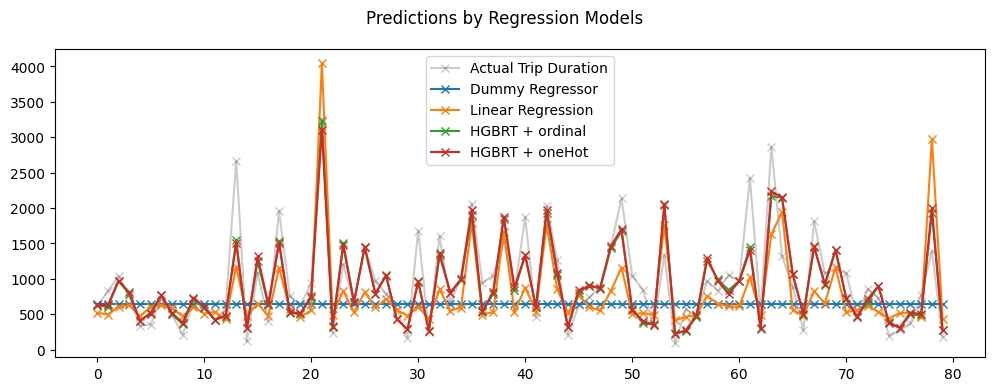

In [ ]:
few_records = slice(-80, None)
fig, ax = plt.subplots(figsize=(12, 4))
fig.suptitle("Predictions by Regression Models")
ax.plot(
    y_train.iloc[test_3].values[few_records],
    "x-",
    alpha=0.2,
    label="Actual Trip Duration",
    color="black",
)
ax.plot(
    dummy_reg_predictions[few_records],
    "x-",
    label="Dummy Regressor", # Model 1
)
ax.plot(
    linear_predictions[few_records],
    "x-",
    label="Linear Regression", # Model 2
)
ax.plot(
    hgbrt_ordinal_predictions[few_records],
    "x-",
    label="HGBRT + ordinal", # Model 3
)
ax.plot(
    hgbrt_one_hot_predictions[few_records],
    "x-",
    label="HGBRT + oneHot", # Model 4
)
_ = ax.legend()

We can draw the following conclusions from the above plot:

*   The performance of the Linear Regression model is superior to that of the Dummy Regressor (which predicts the mean value each time), but it is notable that the Linear Regression model frequently underestimates the trip duration.

*   It has been observed that Gradient Boosting Regression Trees perform significantly better than Linear Regression models, and that encoding categorical variables as ordinal or one-hot has minimal to negligible impact on the performance of the model.

*   We have also noted that none of the models have been successful in accurately predicting the trip duration. However, it's worth noting that gradient boosted trees might give better results than other models.

* Here are some things you can try to boost performance:

    1.   One solution is to plot the correlation matrix and treat features with high correlations if required (depending on if two or more highly correlated features are providing same or different information).

    2.   An approach worth considering is generating a plot of feature importance and selecting only those features that have a significant impact on the predictions.

    3.   Additionally, a potential strategy could involve categorizing timesteps, such as *`hour`*, *`minute`*, *`week`* etc., as categorical variables instead of numerical ones.

    4.   Moreover, we can evaluate whether it is necessary to incorporate additional features, such as weather conditions or area codes.
    
          * To incorporate a weather feature generated from the data available, a weather API like that from [Visual Crossing](https://www.visualcrossing.com/) can be used.

          (It comes at a price.)

          * A library such as 'GeoPy' can be utilized to generate zipcodes.

          (Attempts to use 'GeoPy' resulted in system failure, likely due to the large number of records and insufficient RAM.)

            **NOTE:** Although we are not currently implementing the fourth point for reasons mentioned above, it may be worthwhile to attempt it if possible.